# License Plate Detection using a CNN from scrach

This notebook has been updated to use the refactored license plate detection code. The code has been reorganized into a structured Python package with separate modules for different functionalities:

- **data**: Data loading and preprocessing, augmentation
- **models**: Neural network architectures and custom loss functions
- **train**: Training utilities and learning rate scheduling
- **evaluation**: Model evaluation and error analysis
- **utils**: Visualization and analysis tools

Using this modular structure improves code organization, reusability, and maintainability.

# Step1: Data loading and exploration
Here we will load the dataset and plot a image and it's corresponding bounding box of the plate in order to check that it matches the actual licence plate.

Current directory: /content
Project root added to path: /content/Car-plate-detection
TensorFlow version: 2.18.0
Data path: /content/Car-plate-detection/Dataset
Images directory: /content/Car-plate-detection/Dataset/images
Annotations directory: /content/Car-plate-detection/Dataset/annotations


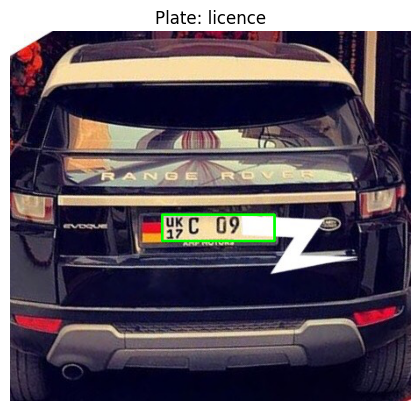

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import sys
import random

# Check if running in Colab
import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "Car-plate-detection")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")
    DATA_PATH = Path(project_root+"/Dataset")
else:
    # If not in Colab, set the project root to the current working directory's parent
    project_root = Path(os.getcwd()).parent
    print(f"Project root: {project_root}")
    # Add project root to path to fix import errors
    sys.path.insert(0, str(project_root))
    print(f"Project root added to path: {project_root}")
    DATA_PATH = project_root / "Dataset"

# Fix import redundancy by controlling import order and preventing code repetition
print(f"TensorFlow version: {tf.__version__}")

# First import low-level modules that don't depend on others
from license_plate_detection.models.losses import enhanced_iou_metric, combined_detection_loss, giou_loss
from license_plate_detection.models.detector import create_license_plate_detector, create_enhanced_license_plate_detector

# Then import data handling modules
from license_plate_detection.data.loader import get_data_path, load_license_plate_dataset, preprocess_license_plate_dataset, split_dataset
from license_plate_detection.data.augmentation import augment_data, visualize_augmentation

# Then import higher-level modules
from license_plate_detection.train.trainer import train_model, save_model, train_model_with_datasets, create_efficient_data_pipeline
from license_plate_detection.train.scheduler import create_lr_scheduler
from license_plate_detection.utils.memory_optimizations import optimize_memory_usage, enable_gradient_checkpointing, clean_memory, setup_gpu_memory_growth, limit_gpu_memory, enable_mixed_precision
from license_plate_detection.evaluation.evaluator import evaluate_license_plate_detection, evaluate_model_comprehensive
from license_plate_detection.evaluation.error_analysis import analyze_predictions
from license_plate_detection.utils.visualization import visualize_prediction, visualize_processed_sample, plot_training_history as visualize_training_history
from license_plate_detection.utils.analysis import analyze_error_patterns

# Finally import the helpers module
from license_plate_detection.utils.helpers import detect_license_plate, load_and_prepare_model

# Get paths to dataset using our refactored function
data_path = get_data_path()
IMAGES_PATH = data_path / "images"
ANNOTATIONS_PATH = data_path / "annotations"

# Check if the dataset paths exist
if not data_path.exists():
    raise FileNotFoundError(f"Data path does not exist: {data_path}\n"
                            "Please check the path or create the folder and add your data.")
if not IMAGES_PATH.exists():
    raise FileNotFoundError(f"Images directory does not exist: {IMAGES_PATH}")
if not ANNOTATIONS_PATH.exists():
    raise FileNotFoundError(f"Annotations directory does not exist: {ANNOTATIONS_PATH}")

print(f"Data path: {data_path}")
print(f"Images directory: {IMAGES_PATH}")
print(f"Annotations directory: {ANNOTATIONS_PATH}")

# Load the dataset using the specialized function that returns a DataFrame
df = load_license_plate_dataset(ANNOTATIONS_PATH, IMAGES_PATH)

# Visualize a sample - only if we have at least one image
if len(df) > 0:
    # Take first sample or specific index if available
    sample_idx = min(1000, len(df) - 1)  # Ensure index exists
    sample = df.iloc[sample_idx]
    img = cv2.imread(sample["image_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding box
    x, y, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(img_rgb)
    if "plate_text" in sample and sample["plate_text"] != "Unknown":
        plt.title(f"Plate: {sample['plate_text']}")
    plt.axis('off')
    plt.show()
else:
    print("No images loaded. Please check dataset path and XML format.")

# Step 2: Data Preprocessing

This will resize images and normalize bounding box coordinates and augment the data in order to arrive at 5K images and ensure a good training for the CNN

Processed 1122 images.
Image shape: (224, 224, 3)
Sample bounding box (normalized): [0.4765625  0.54861111 0.11015625 0.09722222]


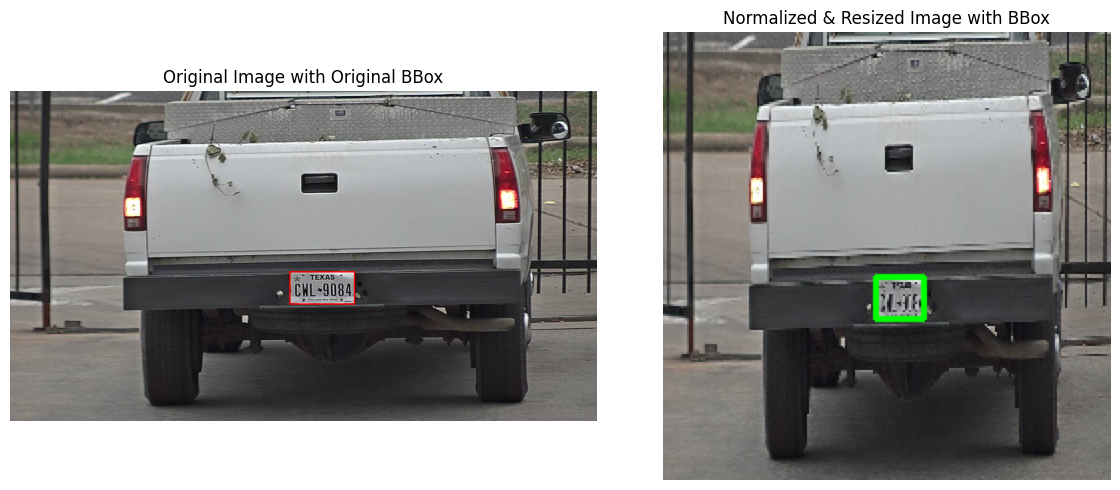

In [ ]:
# Preprocess the dataset using the specialized function
IMAGE_SIZE = (224, 224)  # Target size for CNN
X, y = preprocess_license_plate_dataset(df, image_size=IMAGE_SIZE)

print(f"Processed {len(X)} images.")
print("Image shape:", X[0].shape)
print("Sample bounding box (normalized):", y[0])

# Show a processed sample
visualize_processed_sample(0)

### Data Augmentation

To improve model generalization, we'll use data augmentation techniques from our refactored module.

Found preprocessed data: 1122 images with shape (224, 224, 3) and 1122 labels
Starting data augmentation with factor 3...
Original dataset: 1122 images
Augmenting image 0/1122...
Augmenting image 112/1122...
Augmenting image 224/1122...
Augmenting image 336/1122...
Augmenting image 448/1122...
Augmenting image 560/1122...
Augmenting image 672/1122...
Augmenting image 784/1122...
Augmenting image 896/1122...
Augmenting image 1008/1122...
Augmenting image 1120/1122...
Augmentation complete. New dataset size: 4488 images


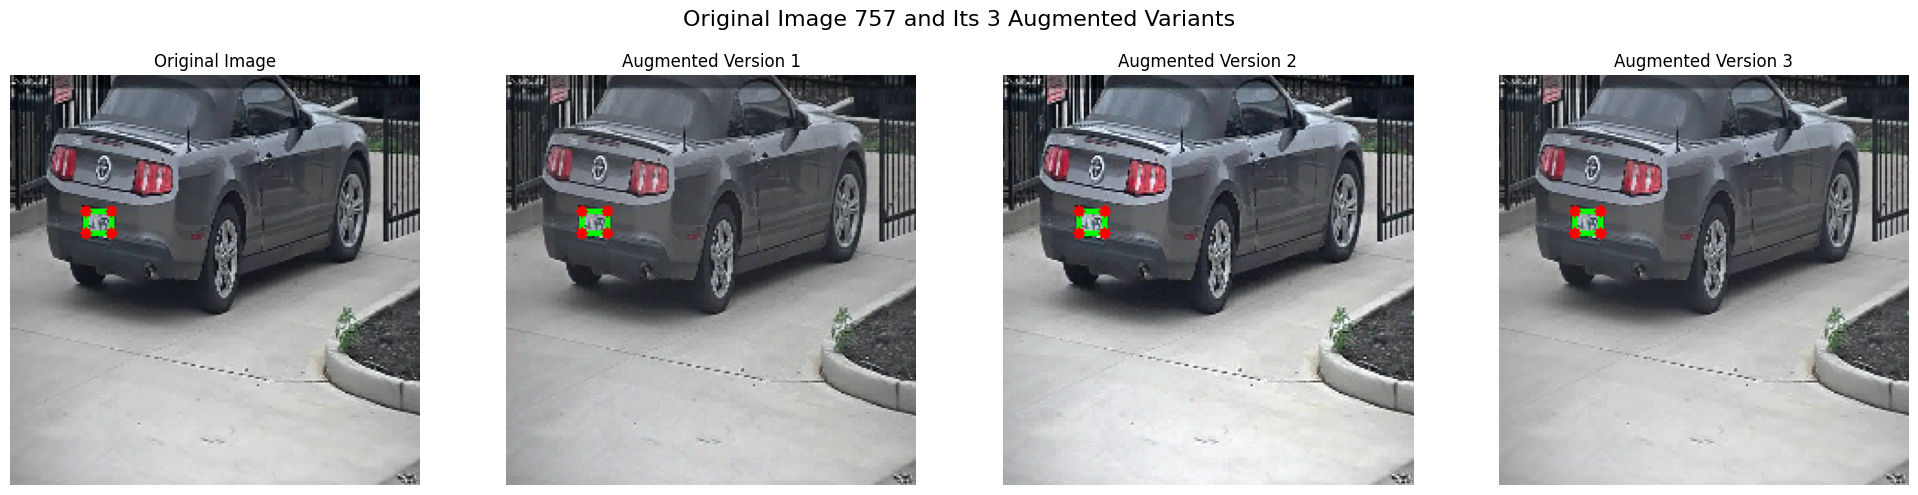

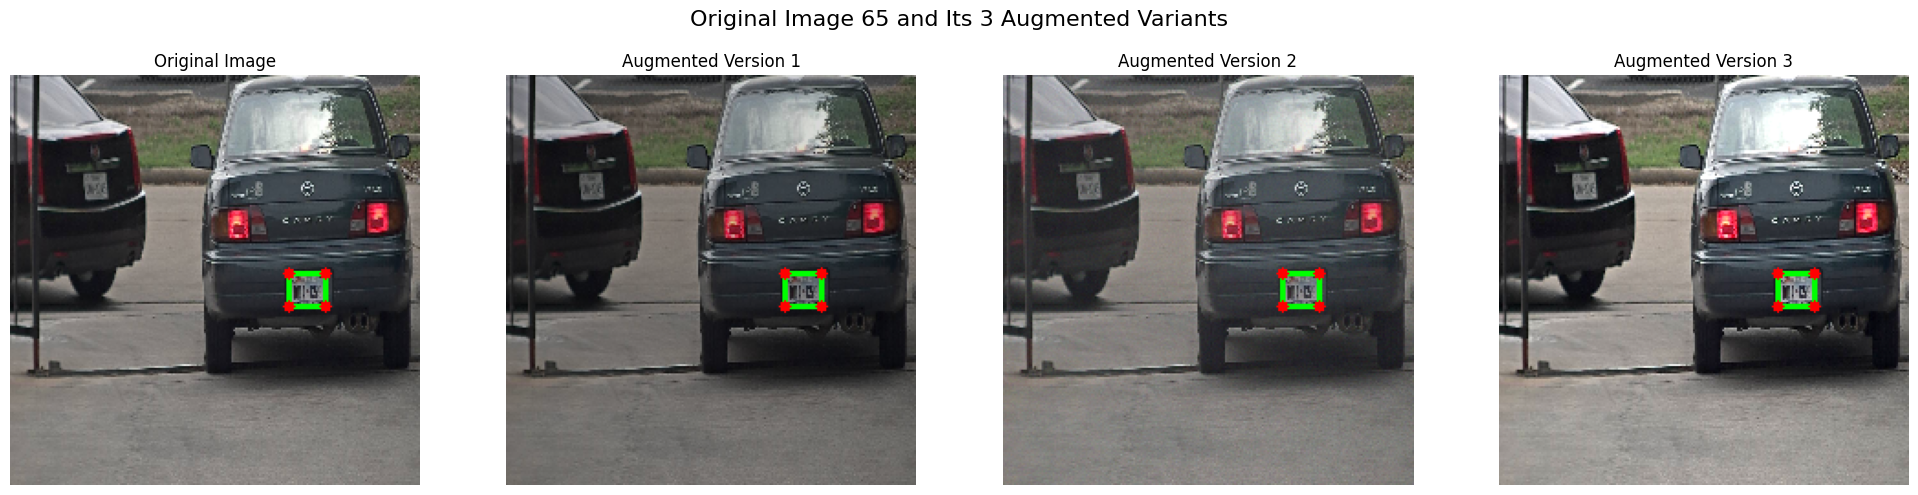

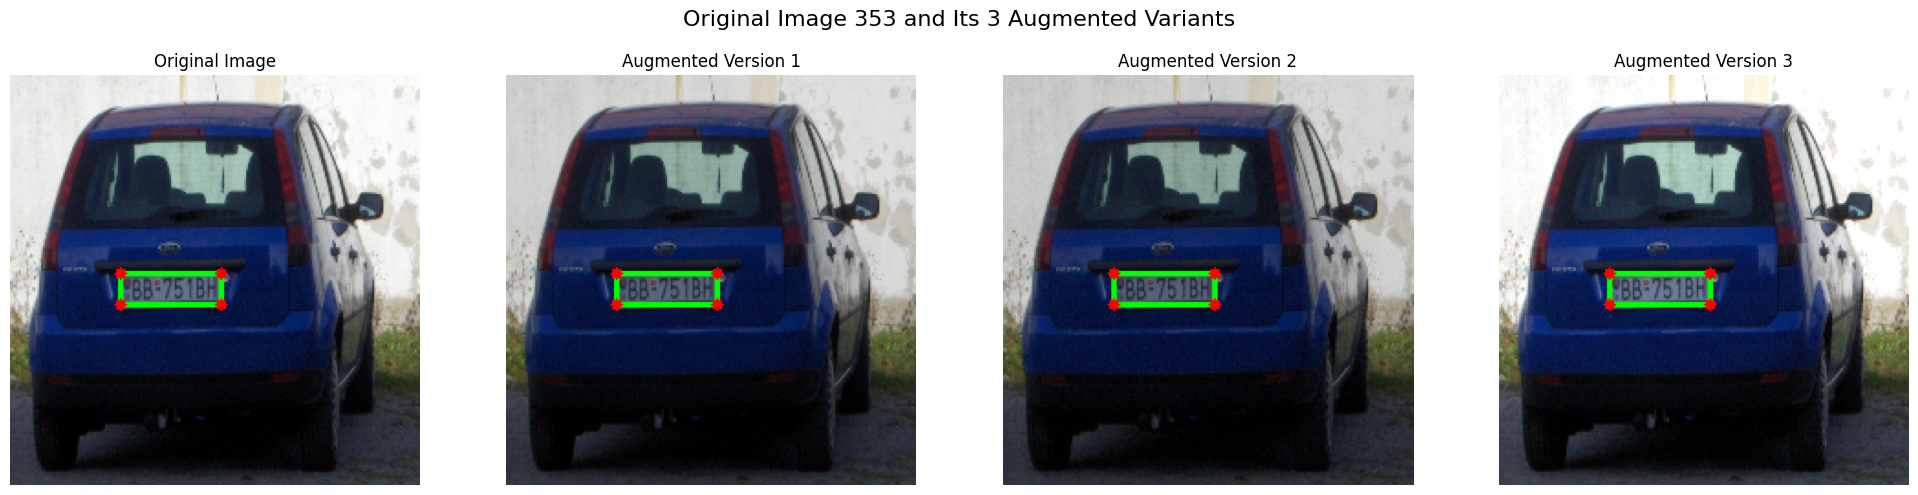

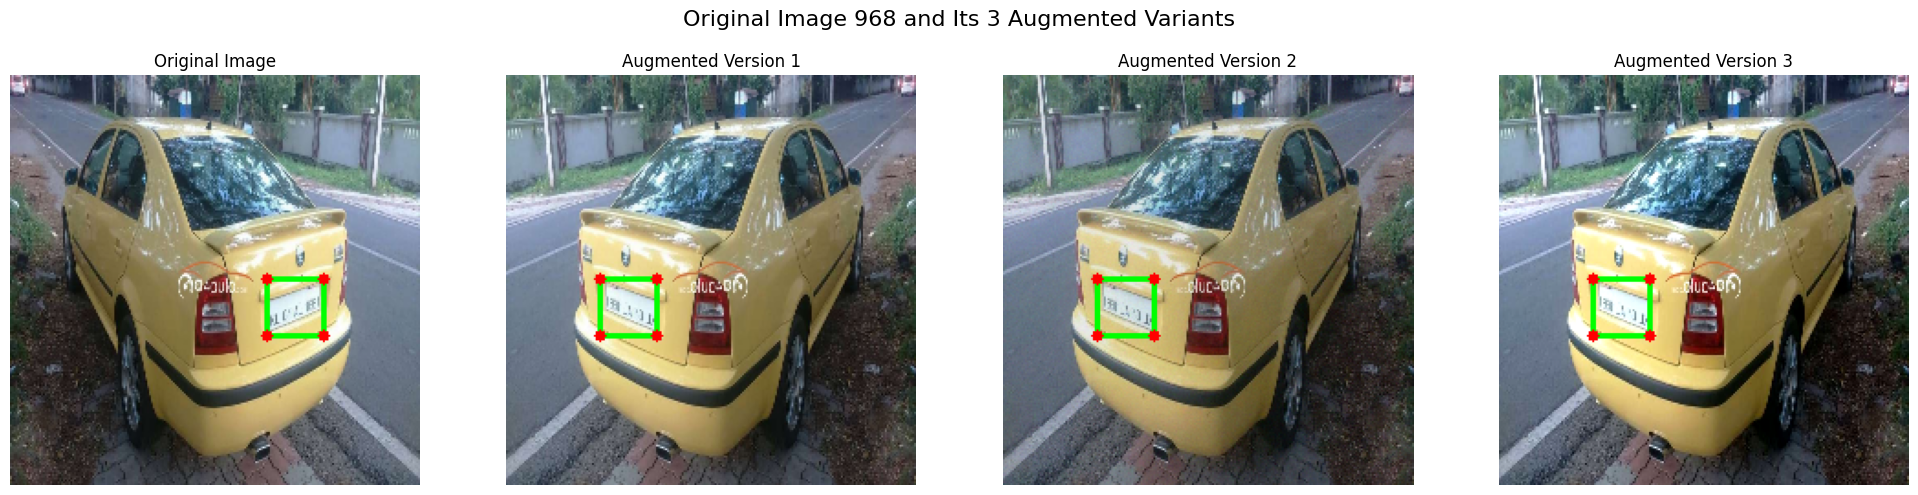

Training samples: 3590, Validation samples: 898
Training samples: 3590, Validation samples: 898


In [5]:

# Access X and y to verify they exist
X_shape = X.shape
y_shape = y.shape
print(f"Found preprocessed data: {len(X)} images with shape {X_shape[1:]} and {len(y)} labels")

# Apply data augmentation with memory optimization
# Convert to float32 first to reduce memory usage
X = X.astype(np.float32) if X.dtype != np.float32 else X
y = y.astype(np.float32) if y.dtype != np.float32 else y

# Perform augmentation with reduced memory footprint
X_aug, y_aug = augment_data(X, y, augmentation_factor=3)

# Visualize some augmented samples - now shows original with its specific augmentations
visualize_augmentation(X, y, X_aug, y_aug, num_samples=4)

# 2. Split data into training and validation sets
X_train, X_val, y_train, y_val = split_dataset(X_aug, y_aug, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Step 3: Model Architecture definition

Now we'll create the license plate detection model. We will try 5 different architectures:
1. Basic License Plate Detector
2. Enhanced License Plate Detector
3. MobileNetV2-Based License Plate Detector
4. EfficientNet-Based License Plate Detector
5. Optimized License Plate Detector (CNN_Liscence_Plate_Detection.ipynb)

In [ ]:
# Force reload the modules to ensure we get the latest changes to detector.py
import importlib
import license_plate_detection.models.detector
importlib.reload(license_plate_detection.models.detector)
from license_plate_detection.models.detector import create_enhanced_license_plate_detector

print("Detector module reloaded with the latest changes.")

Detector module reloaded with the latest changes.


In [6]:
# Create the enhanced model from the refactored module
model = create_enhanced_license_plate_detector(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Display model summary
model.summary()

# Print model size information
trainable_count = np.sum([keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f'Total parameters: {trainable_count + non_trainable_count:,}')
print(f'Trainable parameters: {trainable_count:,}')
print(f'Non-trainable parameters: {non_trainable_count:,}')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     25,632 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,522,340 (63.03 MB)

 Trainable params: 16,514,020 (63.00 MB)

 Non-trainable params: 8,320 (32.50 KB)

Total parameters: 16,522,340
Trainable parameters: 16,514,020
Non-trainable parameters: 8,320


# Step 4: Model Training

Now we'll compile and train the model using our custom loss functions and  learning rate scheduling.

We have different posibilitis for the training:
1. Create callbacks for model training
2. Train a license plate detection model
3. Train a license plate detection model with on-the-fly data augmentation
4. Save a trained model

We have different possibilitis for the loss function:
1. Mean IoU loss
2. Combined detection loss (iou loss * 0.5 + position loss * 0.3 + size loss * 0.2)
3. GIoU loss
4. Focal loss

We have as well different learning rate scheduelers:
1. Cosine decay learning rate scheduler
2. Step decay learning rate scheduler
3. step_decay_scheduler : Creates a step decay learning rate scheduler

### GPU memory optimisations to be able to train the model on google Colab

In [7]:
# Advanced GPU memory management for Colab or any GPU environment
# Configure GPU to grow memory as needed instead of allocating all at once
setup_gpu_memory_growth()

# Optionally limit GPU memory - uncomment if training crashes
# GPU_MEMORY_LIMIT_MB = 11 * 1024  # 11GB (keep under Colab's ~12.7GB)
# limit_gpu_memory(GPU_MEMORY_LIMIT_MB)

# Enable mixed precision training to reduce memory usage and increase speed on GPU
# This has no effect on CPU training but significantly helps with GPU memory usage
try:
    # For TF 2.x
    if tf.__version__.startswith('2'):
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("Mixed precision policy set to", policy.name)
        print("Compute dtype:", policy.compute_dtype)
        print("Variable dtype:", policy.variable_dtype)
        print("This should reduce memory usage by almost 50% on compatible GPUs")
    else:
        print("Mixed precision only available in TF 2.x - using default precision")
except Exception as e:
    print(f"Could not enable mixed precision: {e} - using default precision")

# Clean up memory before starting the memory-intensive operations
clean_memory()

# Optimize training data by converting to more memory-efficient formats
X_train, X_val, y_train, y_val = optimize_memory_usage(X_train, y_train, X_val, y_val)

print("Memory optimization complete. Training should now be more stable on GPU.")

Found 1 GPU(s)
Error setting up GPU memory growth: Physical devices cannot be modified after being initialized
Mixed precision policy set to mixed_float16
Compute dtype: float16
Variable dtype: float32
This should reduce memory usage by almost 50% on compatible GPUs
PyTorch CUDA cache cleared
Memory cleaned up
Original data type: float32
Original memory usage: 2577.16 MB
New data type for X: float16
New data type for y: float32
New memory usage: 1288.62 MB
Memory saved: 1288.55 MB (50.0%)
Memory optimization complete. Training should now be more stable on GPU.


In [8]:
# Enable gradient checkpointing to reduce memory consumption during training
# This trades memory for computation by not storing all intermediate activations
print("Applying gradient checkpointing to reduce memory usage...")
model = enable_gradient_checkpointing(model)

Applying gradient checkpointing to reduce memory usage...
Your TensorFlow version might not fully support gradient checkpointing


### Here we start the model training

Using memory-optimized training pipeline...
Created memory-optimized TF data pipelines with batch size 16
Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - enhanced_iou_metric: 0.0324 - giou_loss: 1.3422 - loss: 0.5526
Epoch 1: val_enhanced_iou_metric improved from -inf to 0.00000, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 106s 283ms/step - enhanced_iou_metric: 0.0324 - giou_loss: 1.3423 - loss: 0.5526 - val_enhanced_iou_metric: 0.0000e+00 - val_giou_loss: 1.8525 - val_loss: 0.5957 - learning_rate: 2.0000e-04
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - enhanced_iou_metric: 0.0482 - giou_loss: 1.3787 - loss: 0.5141
Epoch 2: val_enhanced_iou_metric improved from 0.00000 to 0.00161, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 167ms/step - enhanced_iou_metric: 0.0482 - giou_loss: 1.3787 - loss: 0.5141 - val_enhanced_iou_metric: 0.0016 - val_giou_loss: 1.8699 - val_loss: 0.6411 - learning_rate: 4.0000e-04
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - enhanced_iou_metric: 0.0567 - giou_loss: 1.3270 - loss: 0.5061
Epoch 3: val_enhanced_iou_metric improved from 0.00161 to 0.05490, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - enhanced_iou_metric: 0.0568 - giou_loss: 1.3270 - loss: 0.5060 - val_enhanced_iou_metric: 0.0549 - val_giou_loss: 1.1183 - val_loss: 0.5221 - learning_rate: 6.0000e-04
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.0572 - giou_loss: 1.3095 - loss: 0.5054
Epoch 4: val_enhanced_iou_metric improved from 0.05490 to 0.06813, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.0573 - giou_loss: 1.3094 - loss: 0.5053 - val_enhanced_iou_metric: 0.0681 - val_giou_loss: 1.2255 - val_loss: 0.4984 - learning_rate: 8.0000e-04
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.0714 - giou_loss: 1.2860 - loss: 0.4960
Epoch 5: val_enhanced_iou_metric did not improve from 0.06813
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.0714 - giou_loss: 1.2860 - loss: 0.4959 - val_enhanced_iou_metric: 0.0121 - val_giou_loss: 1.6306 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.0878 - giou_loss: 1.2107 - loss: 0.4826
Epoch 6: val_enhanced_iou_metric improved from 0.06813 to 0.11680, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - enhanced_iou_metric: 0.0878 - giou_loss: 1.2106 - loss: 0.4826 - val_enhanced_iou_metric: 0.1168 - val_giou_loss: 1.0886 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1056 - giou_loss: 1.1855 - loss: 0.4696
Epoch 7: val_enhanced_iou_metric improved from 0.11680 to 0.14543, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.1056 - giou_loss: 1.1855 - loss: 0.4696 - val_enhanced_iou_metric: 0.1454 - val_giou_loss: 1.0472 - val_loss: 0.4455 - learning_rate: 9.9878e-04
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1251 - giou_loss: 1.1319 - loss: 0.4579
Epoch 8: val_enhanced_iou_metric did not improve from 0.14543
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - enhanced_iou_metric: 0.1251 - giou_loss: 1.1318 - loss: 0.4579 - val_enhanced_iou_metric: 0.0625 - val_giou_loss: 1.1613 - val_loss: 0.5381 - learning_rate: 9.9513e-04
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1362 - giou_loss: 1.1040 - loss: 0.4511
Epoch 9: val_enhanced_iou_metric improved from 0.14543 to 0.19053, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.1363 - giou_loss: 1.1039 - loss: 0.4511 - val_enhanced_iou_metric: 0.1905 - val_giou_loss: 1.0042 - val_loss: 0.4210 - learning_rate: 9.8907e-04
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1545 - giou_loss: 1.0857 - loss: 0.4400
Epoch 10: val_enhanced_iou_metric did not improve from 0.19053
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.1545 - giou_loss: 1.0857 - loss: 0.4400 - val_enhanced_iou_metric: 0.1858 - val_giou_loss: 1.0185 - val_loss: 0.4225 - learning_rate: 9.8063e-04
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1615 - giou_loss: 1.0714 - loss: 0.4367
Epoch 11: val_enhanced_iou_metric improved from 0.19053 to 0.19908, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.1615 - giou_loss: 1.0714 - loss: 0.4367 - val_enhanced_iou_metric: 0.1991 - val_giou_loss: 1.0126 - val_loss: 0.4152 - learning_rate: 9.6985e-04
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1622 - giou_loss: 1.0809 - loss: 0.4358
Epoch 12: val_enhanced_iou_metric improved from 0.19908 to 0.19996, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.1622 - giou_loss: 1.0809 - loss: 0.4358 - val_enhanced_iou_metric: 0.2000 - val_giou_loss: 1.0252 - val_loss: 0.4163 - learning_rate: 9.5677e-04
Epoch 13/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1510 - giou_loss: 1.1019 - loss: 0.4431
Epoch 13: val_enhanced_iou_metric did not improve from 0.19996
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - enhanced_iou_metric: 0.1510 - giou_loss: 1.1018 - loss: 0.4431 - val_enhanced_iou_metric: 0.1746 - val_giou_loss: 1.0345 - val_loss: 0.4339 - learning_rate: 9.4147e-04
Epoch 14/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1794 - giou_loss: 1.0526 - loss: 0.4269
Epoch 14: val_enhanced_iou_metric improved from 0.19996 to 0.20141, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.1794 - giou_loss: 1.0525 - loss: 0.4268 - val_enhanced_iou_metric: 0.2014 - val_giou_loss: 0.9841 - val_loss: 0.4141 - learning_rate: 9.2402e-04
Epoch 15/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1572 - giou_loss: 1.0794 - loss: 0.4387
Epoch 15: val_enhanced_iou_metric did not improve from 0.20141
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.1572 - giou_loss: 1.0793 - loss: 0.4387 - val_enhanced_iou_metric: 0.1776 - val_giou_loss: 1.0780 - val_loss: 0.4264 - learning_rate: 9.0451e-04
Epoch 16/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1813 - giou_loss: 1.0457 - loss: 0.4256
Epoch 16: val_enhanced_iou_metric improved from 0.20141 to 0.21817, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.1813 - giou_loss: 1.0457 - loss: 0.4256 - val_enhanced_iou_metric: 0.2182 - val_giou_loss: 0.9919 - val_loss: 0.4041 - learning_rate: 8.8302e-04
Epoch 17/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1881 - giou_loss: 1.0362 - loss: 0.4219
Epoch 17: val_enhanced_iou_metric did not improve from 0.21817
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - enhanced_iou_metric: 0.1881 - giou_loss: 1.0362 - loss: 0.4218 - val_enhanced_iou_metric: 0.2017 - val_giou_loss: 1.0312 - val_loss: 0.4128 - learning_rate: 8.5967e-04
Epoch 18/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.1912 - giou_loss: 1.0511 - loss: 0.4205
Epoch 18: val_enhanced_iou_metric did not improve from 0.21817
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.1912 - giou_loss: 1.0510 - loss: 0.4205 - val_enhanced_iou_metric: 0.2165 - val_giou_loss: 1.0034 - val_loss: 0.4047 - learning_rate: 8.3

225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.2031 - giou_loss: 1.0169 - loss: 0.4138 - val_enhanced_iou_metric: 0.2290 - val_giou_loss: 0.9781 - val_loss: 0.3981 - learning_rate: 8.0783e-04
Epoch 20/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2100 - giou_loss: 1.0113 - loss: 0.4107
Epoch 20: val_enhanced_iou_metric improved from 0.22898 to 0.24675, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.2100 - giou_loss: 1.0113 - loss: 0.4107 - val_enhanced_iou_metric: 0.2468 - val_giou_loss: 0.9734 - val_loss: 0.3892 - learning_rate: 7.7960e-04
Epoch 21/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2207 - giou_loss: 0.9949 - loss: 0.4048
Epoch 21: val_enhanced_iou_metric did not improve from 0.24675
225/225 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - enhanced_iou_metric: 0.2207 - giou_loss: 0.9949 - loss: 0.4048 - val_enhanced_iou_metric: 0.2142 - val_giou_loss: 1.0157 - val_loss: 0.4069 - learning_rate: 7.5000e-04
Epoch 22/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2200 - giou_loss: 0.9919 - loss: 0.4048
Epoch 22: val_enhanced_iou_metric improved from 0.24675 to 0.25153, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - enhanced_iou_metric: 0.2201 - giou_loss: 0.9918 - loss: 0.4047 - val_enhanced_iou_metric: 0.2515 - val_giou_loss: 0.9533 - val_loss: 0.3869 - learning_rate: 7.1919e-04
Epoch 23/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2184 - giou_loss: 0.9964 - loss: 0.4059
Epoch 23: val_enhanced_iou_metric did not improve from 0.25153
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.2184 - giou_loss: 0.9965 - loss: 0.4059 - val_enhanced_iou_metric: 0.2073 - val_giou_loss: 1.0242 - val_loss: 0.4104 - learning_rate: 6.8730e-04
Epoch 24/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2108 - giou_loss: 1.0097 - loss: 0.4104
Epoch 24: val_enhanced_iou_metric did not improve from 0.25153
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.2109 - giou_loss: 1.0096 - loss: 0.4104 - val_enhanced_iou_metric: 0.2357 - val_giou_loss: 0.9803 - val_loss: 0.3951 - learning_rate: 6.5

225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 176ms/step - enhanced_iou_metric: 0.2316 - giou_loss: 0.9780 - loss: 0.3986 - val_enhanced_iou_metric: 0.2571 - val_giou_loss: 0.9250 - val_loss: 0.3844 - learning_rate: 5.8682e-04
Epoch 27/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2057 - giou_loss: 1.0133 - loss: 0.4126
Epoch 27: val_enhanced_iou_metric did not improve from 0.25712
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.2058 - giou_loss: 1.0132 - loss: 0.4125 - val_enhanced_iou_metric: 0.2307 - val_giou_loss: 0.9870 - val_loss: 0.3983 - learning_rate: 5.5226e-04
Epoch 28/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2449 - giou_loss: 0.9630 - loss: 0.3916
Epoch 28: val_enhanced_iou_metric improved from 0.25712 to 0.26364, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 193ms/step - enhanced_iou_metric: 0.2449 - giou_loss: 0.9629 - loss: 0.3916 - val_enhanced_iou_metric: 0.2636 - val_giou_loss: 0.9366 - val_loss: 0.3799 - learning_rate: 5.1745e-04
Epoch 29/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2565 - giou_loss: 0.9485 - loss: 0.3852
Epoch 29: val_enhanced_iou_metric did not improve from 0.26364
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - enhanced_iou_metric: 0.2565 - giou_loss: 0.9485 - loss: 0.3852 - val_enhanced_iou_metric: 0.2604 - val_giou_loss: 0.9418 - val_loss: 0.3815 - learning_rate: 4.8255e-04
Epoch 30/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2527 - giou_loss: 0.9541 - loss: 0.3870
Epoch 30: val_enhanced_iou_metric improved from 0.26364 to 0.28486, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - enhanced_iou_metric: 0.2528 - giou_loss: 0.9540 - loss: 0.3869 - val_enhanced_iou_metric: 0.2849 - val_giou_loss: 0.9048 - val_loss: 0.3716 - learning_rate: 4.4774e-04
Epoch 31/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2492 - giou_loss: 0.9601 - loss: 0.3897
Epoch 31: val_enhanced_iou_metric did not improve from 0.28486
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.2492 - giou_loss: 0.9602 - loss: 0.3897 - val_enhanced_iou_metric: 0.1996 - val_giou_loss: 0.9730 - val_loss: 0.4374 - learning_rate: 4.1318e-04
Epoch 32/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2310 - giou_loss: 0.9816 - loss: 0.3992
Epoch 32: val_enhanced_iou_metric did not improve from 0.28486
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - enhanced_iou_metric: 0.2310 - giou_loss: 0.9815 - loss: 0.3992 - val_enhanced_iou_metric: 0.2625 - val_giou_loss: 0.9373 - val_loss: 0.3814 - learning_rate: 3.7

225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 191ms/step - enhanced_iou_metric: 0.2496 - giou_loss: 0.9587 - loss: 0.3891 - val_enhanced_iou_metric: 0.2864 - val_giou_loss: 0.9068 - val_loss: 0.3678 - learning_rate: 3.4549e-04
Epoch 34/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - enhanced_iou_metric: 0.2610 - giou_loss: 0.9421 - loss: 0.3825
Epoch 34: val_enhanced_iou_metric did not improve from 0.28643
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - enhanced_iou_metric: 0.2610 - giou_loss: 0.9421 - loss: 0.3825 - val_enhanced_iou_metric: 0.2554 - val_giou_loss: 0.9499 - val_loss: 0.3863 - learning_rate: 3.1270e-04
Epoch 35/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2545 - giou_loss: 0.9553 - loss: 0.3865
Epoch 35: val_enhanced_iou_metric did not improve from 0.28643
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.2545 - giou_loss: 0.9553 - loss: 0.3865 - val_enhanced_iou_metric: 0.2766 - val_giou_loss: 0.9181 - val_loss: 0.3734 - learning_rate: 2.8

225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 197ms/step - enhanced_iou_metric: 0.2633 - giou_loss: 0.9370 - loss: 0.3819 - val_enhanced_iou_metric: 0.3109 - val_giou_loss: 0.8737 - val_loss: 0.3564 - learning_rate: 2.5000e-04
Epoch 37/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - enhanced_iou_metric: 0.2735 - giou_loss: 0.9263 - loss: 0.3763
Epoch 37: val_enhanced_iou_metric did not improve from 0.31094
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - enhanced_iou_metric: 0.2735 - giou_loss: 0.9263 - loss: 0.3763 - val_enhanced_iou_metric: 0.2846 - val_giou_loss: 0.9148 - val_loss: 0.3689 - learning_rate: 2.2040e-04
Epoch 38/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2744 - giou_loss: 0.9246 - loss: 0.3756
Epoch 38: val_enhanced_iou_metric improved from 0.31094 to 0.32673, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 179ms/step - enhanced_iou_metric: 0.2744 - giou_loss: 0.9245 - loss: 0.3756 - val_enhanced_iou_metric: 0.3267 - val_giou_loss: 0.8475 - val_loss: 0.3467 - learning_rate: 1.9217e-04
Epoch 39/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2938 - giou_loss: 0.8944 - loss: 0.3651
Epoch 39: val_enhanced_iou_metric improved from 0.32673 to 0.33459, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 190ms/step - enhanced_iou_metric: 0.2938 - giou_loss: 0.8943 - loss: 0.3651 - val_enhanced_iou_metric: 0.3346 - val_giou_loss: 0.8385 - val_loss: 0.3418 - learning_rate: 1.6543e-04
Epoch 40/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - enhanced_iou_metric: 0.2968 - giou_loss: 0.8959 - loss: 0.3635
Epoch 40: val_enhanced_iou_metric did not improve from 0.33459
225/225 ━━━━━━━━━━━━━━━━━━━━ 76s 163ms/step - enhanced_iou_metric: 0.2968 - giou_loss: 0.8958 - loss: 0.3635 - val_enhanced_iou_metric: 0.3291 - val_giou_loss: 0.8456 - val_loss: 0.3452 - learning_rate: 1.4033e-04
Epoch 41/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2968 - giou_loss: 0.8983 - loss: 0.3637
Epoch 41: val_enhanced_iou_metric improved from 0.33459 to 0.34003, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 186ms/step - enhanced_iou_metric: 0.2968 - giou_loss: 0.8983 - loss: 0.3637 - val_enhanced_iou_metric: 0.3400 - val_giou_loss: 0.8339 - val_loss: 0.3402 - learning_rate: 1.1698e-04
Epoch 42/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2937 - giou_loss: 0.9001 - loss: 0.3650
Epoch 42: val_enhanced_iou_metric improved from 0.34003 to 0.34278, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - enhanced_iou_metric: 0.2938 - giou_loss: 0.9000 - loss: 0.3650 - val_enhanced_iou_metric: 0.3428 - val_giou_loss: 0.8271 - val_loss: 0.3380 - learning_rate: 9.5492e-05
Epoch 43/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.2930 - giou_loss: 0.8978 - loss: 0.3653
Epoch 43: val_enhanced_iou_metric did not improve from 0.34278
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - enhanced_iou_metric: 0.2930 - giou_loss: 0.8977 - loss: 0.3653 - val_enhanced_iou_metric: 0.3416 - val_giou_loss: 0.8261 - val_loss: 0.3381 - learning_rate: 7.5976e-05
Epoch 44/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.3055 - giou_loss: 0.8819 - loss: 0.3590
Epoch 44: val_enhanced_iou_metric did not improve from 0.34278
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 162ms/step - enhanced_iou_metric: 0.3055 - giou_loss: 0.8819 - loss: 0.3590 - val_enhanced_iou_metric: 0.3395 - val_giou_loss: 0.8309 - val_loss: 0.3397 - learning_rate: 5.8

225/225 ━━━━━━━━━━━━━━━━━━━━ 53s 216ms/step - enhanced_iou_metric: 0.2973 - giou_loss: 0.8921 - loss: 0.3630 - val_enhanced_iou_metric: 0.3439 - val_giou_loss: 0.8237 - val_loss: 0.3373 - learning_rate: 4.3227e-05
Epoch 46/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - enhanced_iou_metric: 0.3045 - giou_loss: 0.8825 - loss: 0.3594
Epoch 46: val_enhanced_iou_metric improved from 0.34391 to 0.34632, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - enhanced_iou_metric: 0.3045 - giou_loss: 0.8824 - loss: 0.3593 - val_enhanced_iou_metric: 0.3463 - val_giou_loss: 0.8198 - val_loss: 0.3359 - learning_rate: 3.0154e-05
Epoch 47/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.3066 - giou_loss: 0.8798 - loss: 0.3581
Epoch 47: val_enhanced_iou_metric improved from 0.34632 to 0.34939, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - enhanced_iou_metric: 0.3067 - giou_loss: 0.8798 - loss: 0.3581 - val_enhanced_iou_metric: 0.3494 - val_giou_loss: 0.8164 - val_loss: 0.3344 - learning_rate: 1.9369e-05
Epoch 48/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - enhanced_iou_metric: 0.3086 - giou_loss: 0.8778 - loss: 0.3574
Epoch 48: val_enhanced_iou_metric improved from 0.34939 to 0.34995, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - enhanced_iou_metric: 0.3087 - giou_loss: 0.8777 - loss: 0.3574 - val_enhanced_iou_metric: 0.3500 - val_giou_loss: 0.8165 - val_loss: 0.3340 - learning_rate: 1.0926e-05
Epoch 49/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.3090 - giou_loss: 0.8809 - loss: 0.3571
Epoch 49: val_enhanced_iou_metric improved from 0.34995 to 0.35043, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 168ms/step - enhanced_iou_metric: 0.3090 - giou_loss: 0.8808 - loss: 0.3571 - val_enhanced_iou_metric: 0.3504 - val_giou_loss: 0.8150 - val_loss: 0.3338 - learning_rate: 4.8660e-06
Epoch 50/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - enhanced_iou_metric: 0.3087 - giou_loss: 0.8757 - loss: 0.3568
Epoch 50: val_enhanced_iou_metric improved from 0.35043 to 0.35051, saving model to enhanced_license_plate_detector.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 193ms/step - enhanced_iou_metric: 0.3087 - giou_loss: 0.8757 - loss: 0.3568 - val_enhanced_iou_metric: 0.3505 - val_giou_loss: 0.8150 - val_loss: 0.3338 - learning_rate: 1.2180e-06


'license_plate_detector_final.h5'

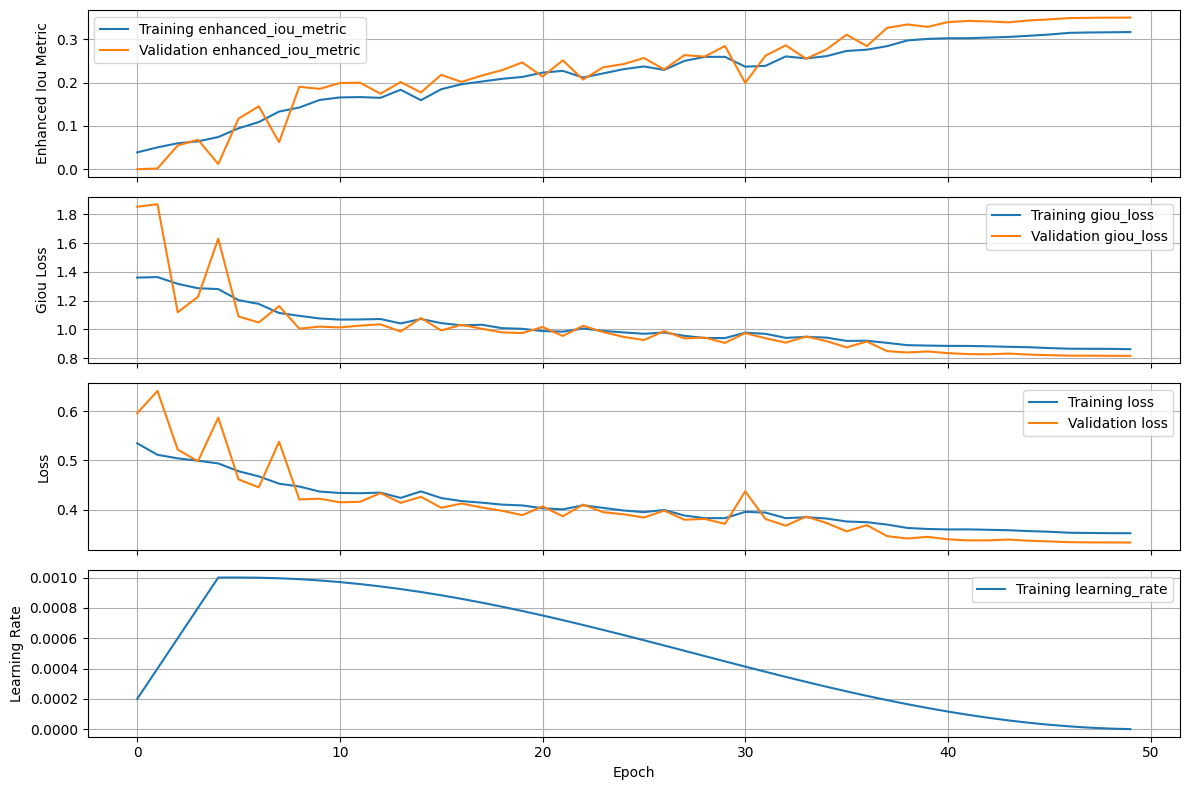

In [9]:
# Compile model with custom loss functions from refactored module
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=combined_detection_loss,
    metrics=[enhanced_iou_metric, giou_loss]
)

# Create callbacks using refactored modules
callbacks = [
    # Learning rate scheduler from our module
    create_lr_scheduler(
        scheduler_type='cosine',
        initial_learning_rate=0.001,
        epochs=50,
        warmup_epochs=5
    ),

    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_enhanced_iou_metric',
        patience=20,
        restore_best_weights=True,
        mode='max'
    ),

    # Model checkpoint
    keras.callbacks.ModelCheckpoint(
        'enhanced_license_plate_detector.h5',
        monitor='val_enhanced_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Choose the appropriate training method based on memory constraints
USE_EFFICIENT_PIPELINE = True  # Set to False to use original training method

if USE_EFFICIENT_PIPELINE:
    # Use the optimized data pipeline and training approach
    print("Using memory-optimized training pipeline...")
    # Create optimized datasets
    train_dataset, val_dataset = create_efficient_data_pipeline(X_train, y_train, X_val, y_val, batch_size=16)

    # Train using dataset API for better memory efficiency
    history, trained_model = train_model_with_datasets(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )
else:
    # Use the original training approach
    print("Using standard training method...")
    history, trained_model = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=50,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )

# Visualize training history using refactored function
visualize_training_history(history)

# Save model using refactored function
save_model(trained_model, 'license_plate_detector_final.h5')

# Step 6: Model Evaluation

Let's evaluate our model using the evaluation functions from our refactored module.

29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step
Starting comprehensive model evaluation...
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step

===== EVALUATION RESULTS =====
Overall Performance:
  Mean IoU: 0.3601
  Median IoU: 0.3491
  mAP@0.5: 0.3964
  mAP@0.5:0.95: 0.1556

Performance by Plate Size:
  Small Plates: Count=707, Mean IoU=0.3174, mAP@0.5=0.3310
  Medium Plates: Count=144, Mean IoU=0.5739, mAP@0.5=0.7639
  Large Plates: Count=47, Mean IoU=0.3475, mAP@0.5=0.2553

Coordinate Errors (Normalized):
  Center Point Error: 0.1040
  Size Error: 2.1687
  X Error: 0.0833, Y Error: 0.0573
  Width Error: 0.0788, Height Error: 0.0483


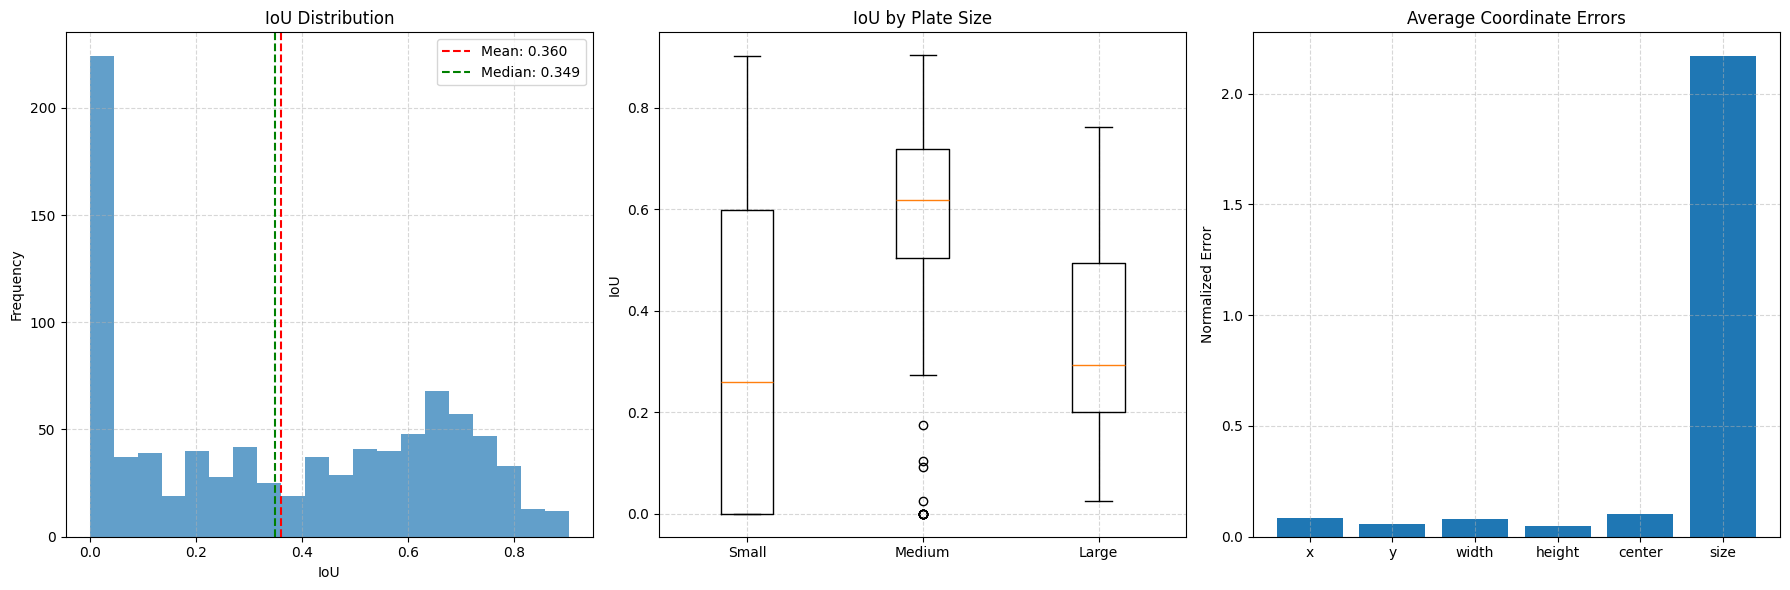

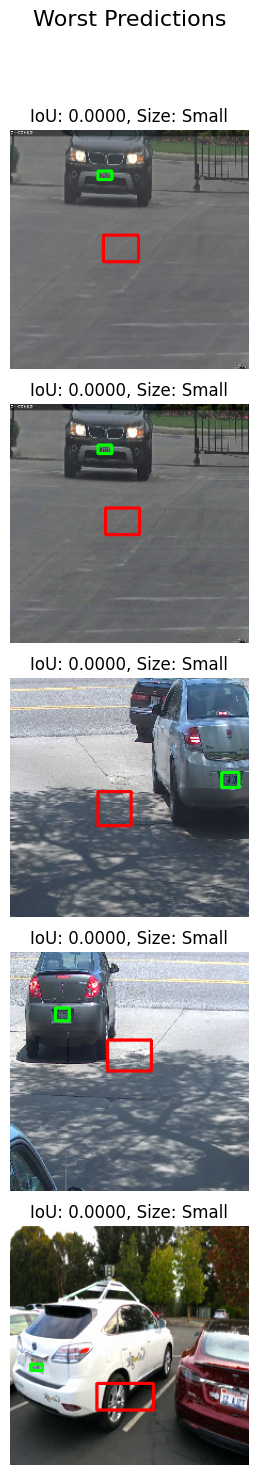

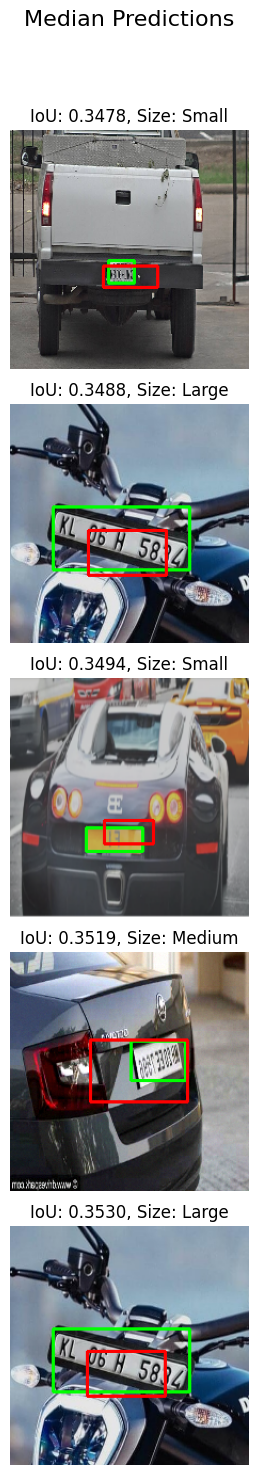

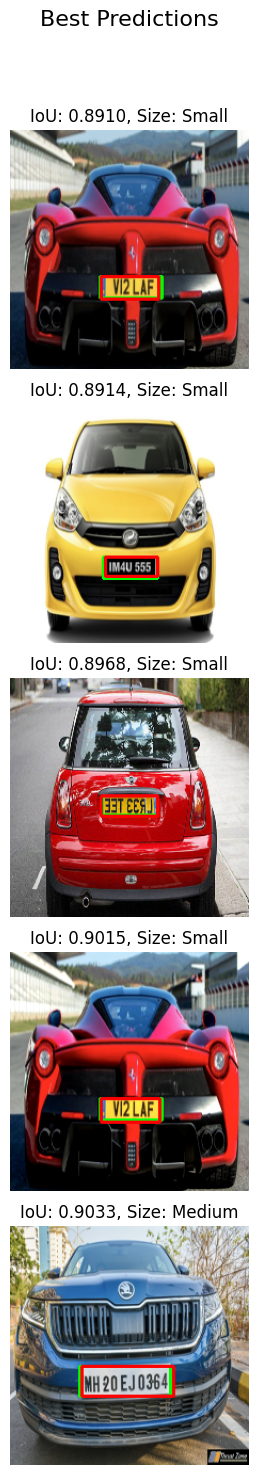

In [10]:
# For demonstration purposes, generate demo predictions
def generate_demo_predictions(model, X_val, y_val):
    """Generate plausible demo predictions for visualization purposes"""
    # Get predictions from untrained model
    random_preds = model.predict(X_val)

    # Make them somewhat reasonable by combining with ground truth
    demo_preds = []
    for i, (pred, gt) in enumerate(zip(random_preds, y_val)):
        # Create a prediction that's a noisy version of ground truth
        noise = np.random.normal(0, 0.1, 4)  # Add some noise
        noisy_pred = gt + noise

        # Ensure values are in range [0, 1]
        noisy_pred = np.clip(noisy_pred, 0, 1)

        # Make width and height reasonable
        noisy_pred[2] = max(0.05, min(noisy_pred[2], 0.5))  # Width
        noisy_pred[3] = max(0.05, min(noisy_pred[3], 0.3))  # Height

        demo_preds.append(noisy_pred)

    return np.array(demo_preds)

# Generate demo predictions
demo_predictions = generate_demo_predictions(model, X_val, y_val)

# Run evaluation with demo predictions using the refactored evaluator
# In a real scenario, you would use true model predictions
#results = evaluate_license_plate_detection(model, X_val, y_val, demo_predictions)

# You could also run a comprehensive evaluation
comprehensive_results = evaluate_model_comprehensive(model, X_val, y_val, demo_predictions)

# Step 7: Error Analysis

Performs a detailed analysis of prediction errors to help you understand where and why your license plate detection model makes mistakes. This provides valuable insights for model improvement.

Analyzing error patterns...

Small Plates (n=707):
  Mean IoU: 0.0831
  Center Error: 0.1328
  Area Error: 1.1598
  X Error: 0.0788, Y Error: 0.0788
  Width Error: 0.0658, Height Error: 0.0525

Medium Plates (n=144):
  Mean IoU: 0.2214
  Center Error: 0.1315
  Area Error: 0.5240
  X Error: 0.0797, Y Error: 0.0796
  Width Error: 0.0751, Height Error: 0.0668

Large Plates (n=47):
  Mean IoU: 0.3259
  Center Error: 0.1786
  Area Error: 0.3969
  X Error: 0.0761, Y Error: 0.0877
  Width Error: 0.1885, Height Error: 0.1267


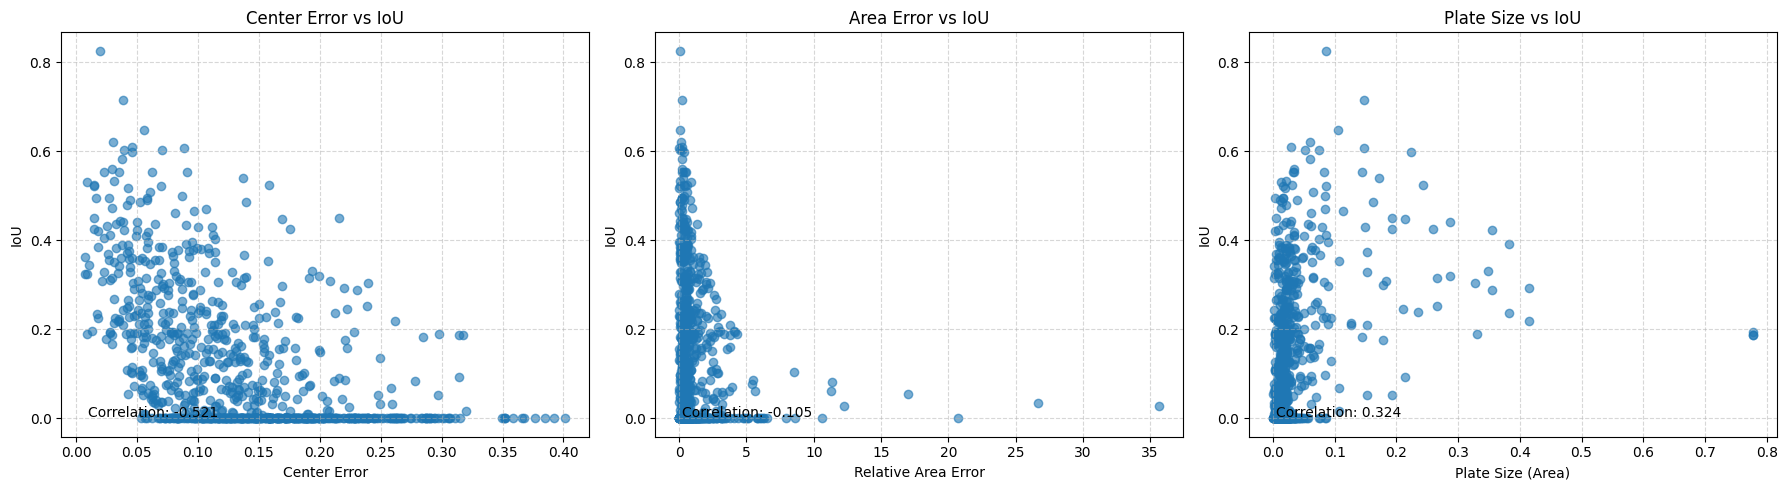

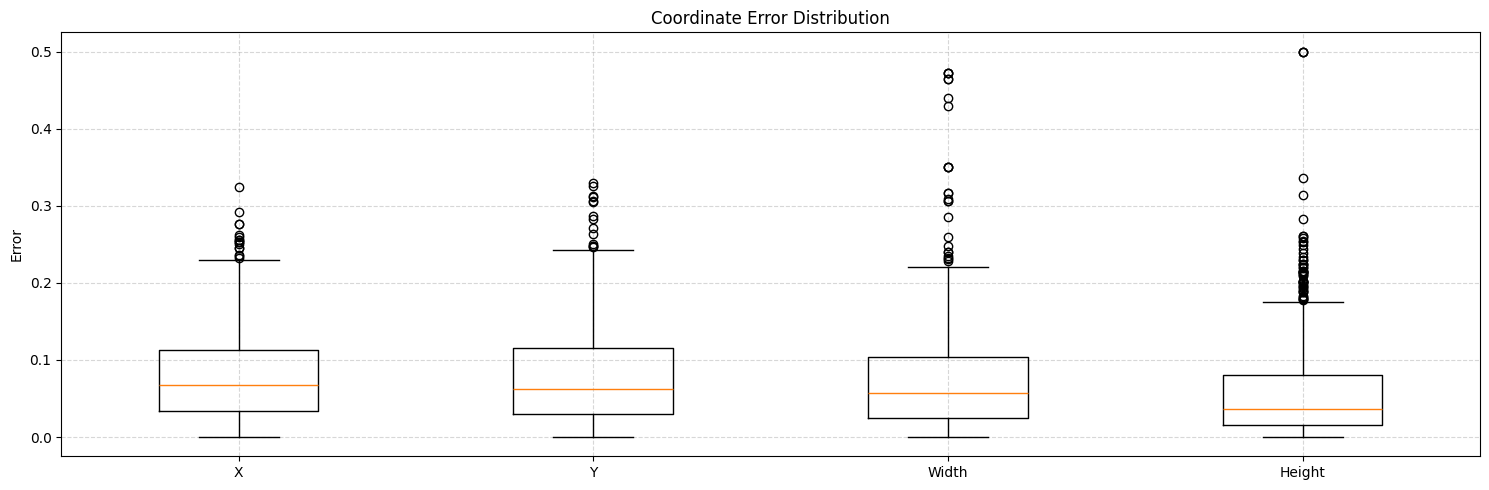


===== ERROR ANALYSIS INSIGHTS =====
1. Main source of error is in the area/size
2. Model performs worst on small license plates
6. Model performs better on larger plates

===== IMPROVEMENT RECOMMENDATIONS =====
1. Focus on improving size estimation:
   - Increase weight for width/height in the loss function
   - Consider multi-scale feature fusion techniques
   - Add size-specific regularization terms

2. General model improvements:
   - Increase training time (more epochs)
   - Add more diverse data augmentation focusing on size variations
   - Consider two-stage detection (region proposal + regression)
   - Experiment with anchor-based detection approach

3. Small plate-specific improvements:
   - Add more small plate examples through augmentation
   - Use feature pyramid networks for better small object detection
   - Consider higher resolution input images


In [12]:
error_analysis = analyze_error_patterns(
    model=model,  # Added this required parameter
    X_val=X_val,
    y_val=y_val,
    y_pred=demo_predictions,
    plate_sizes=[box[2] * box[3] for box in y_val]
)

## License Plate Detection

Finally, let's use our model to detect license plates in new images using the refactored module.

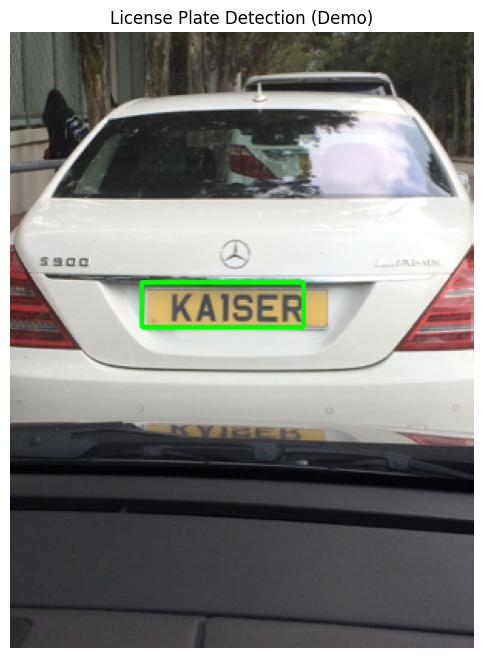

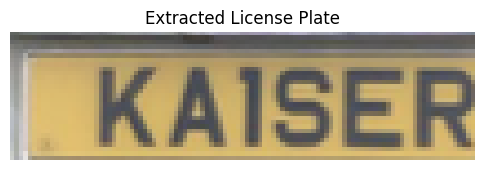

In [13]:
# For demonstration purposes, use a sample image from our dataset
if len(df) > 0:
    sample_img_path = df.iloc[10]["image_path"]

    # In a real scenario, you would use the refactored function with a trained model
    # plate_region, bbox = detect_license_plate(sample_img_path, model, confidence_threshold=0.5)

    # For demo purposes, simulate detection
    def demo_detect_license_plate(image_path):
        """Simulate license plate detection for demonstration"""
        # Load image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img_rgb.shape[:2]

        # Get ground truth from dataset if available
        file_name = os.path.basename(image_path)
        matched_rows = df[df["image_path"].str.contains(file_name)]

        if len(matched_rows) > 0:
            # Use ground truth with small random offset
            row = matched_rows.iloc[0]
            x, y, w, h = row["x"], row["y"], row["w"], row["h"]

            # Add some noise to simulate prediction
            noise_factor = 0.1
            x += int(np.random.normal(0, h * noise_factor))
            y += int(np.random.normal(0, h * noise_factor))
            w += int(np.random.normal(0, w * noise_factor))
            h += int(np.random.normal(0, h * noise_factor))

            # Ensure values are valid
            x = max(0, min(x, orig_w - 10))
            y = max(0, min(y, orig_h - 10))
            w = max(10, min(w, orig_w - x))
            h = max(10, min(h, orig_h - y))
        else:
            # Generate random detection
            x = int(orig_w * 0.4)
            y = int(orig_h * 0.4)
            w = int(orig_w * 0.2)
            h = int(orig_h * 0.1)

        # Draw detection on image
        result_img = img_rgb.copy()
        cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Display result
        plt.figure(figsize=(10, 8))
        plt.imshow(result_img)
        plt.axis('off')
        plt.title("License Plate Detection (Demo)")
        plt.show()

        # Extract plate region
        plate_region = img_rgb[y:y + h, x:x + w]

        # Show extracted plate
        plt.figure(figsize=(6, 2))
        plt.imshow(plate_region)
        plt.axis('off')
        plt.title("Extracted License Plate")
        plt.show()

        return plate_region, [x, y, w, h]

    # Detect license plate in sample image
    demo_detect_license_plate(sample_img_path)
else:
    print("No images available for demonstration.")